In [1]:
# ==========================================
# CPU-friendly TensorFlow/Keras setup
# ==========================================

# For inline plotting in Jupyter
%matplotlib inline

import os

# --- Force TensorFlow to use CPU only ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"      # Disable NVIDIA GPUs
os.environ["KERAS_BACKEND"] = "tensorflow"     # Ensure TensorFlow backend
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"      # Enable optimized CPU ops
os.environ["OMP_NUM_THREADS"] = "4"            # Limit parallel threads
os.environ["MKL_NUM_THREADS"] = "4"            # Avoid CPU overload

# ==========================================
# Data & plotting libraries
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# Scikit-learn utilities
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# ==========================================
# Image processing
# ==========================================
import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage import color, filters, morphology, transform, exposure, feature, util
from scipy import ndimage

# ==========================================
# TensorFlow & Keras setup
# ==========================================
import tensorflow as tf

# Double-check that GPUs are hidden
for dev_type in ["GPU", "TPU", "MPS"]:
    try:
        tf.config.set_visible_devices([], dev_type)
    except Exception:
        pass

# Limit TensorFlow thread usage to keep CPU cool
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.set_soft_device_placement(True)

# Default numeric precision for speed
tf.keras.backend.set_floatx("float32")

# ==========================================
# Keras model components
# ==========================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation, Dense, Dropout, Flatten,
    BatchNormalization, Conv2D, MaxPooling2D
)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

# ==========================================
# Pretrained VGG19 & helpers (optional)
# ==========================================
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

# ==========================================
# Miscellaneous
# ==========================================
import pickle

# ==========================================
# Environment check
# ==========================================
print("TensorFlow device configuration:")
print("Available devices:", tf.config.list_physical_devices())
print("→ GPU:", "Available ✅" if tf.config.list_physical_devices('GPU') else "Not available 🚫")
print("→ Running on CPU only 💻")


TensorFlow device configuration:
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
→ GPU: Not available 🚫
→ Running on CPU only 💻


In [2]:
def unpickle(file):
    """
    Load and return the contents of a pickled file.
    
    Args:
        file (str): Path to the pickled file
        
    Returns:
        dict: The unpickled data as a dictionary
    """
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# Load CIFAR-10 dataset
# The dataset is split into training and test sets
training_data = unpickle('/Users/pascal-maker/Desktop/deeplearning/Session_02_Convolutional_Neural_Networks_Demos/cifar-10/data_batch_1')  # Load training data (first batch)
test_data = unpickle('/Users/pascal-maker/Desktop/deeplearning/Session_02_Convolutional_Neural_Networks_Demos/cifar-10/test_batch')        # Load test data

In [4]:
# Extract features (images) and labels from the loaded data
X_train = training_data.get(b'data')        # Training images
X_test = test_data.get(b'data')             # Test images
train_labels = training_data.get(b'labels')  # Training labels
test_labels = test_data.get(b'labels')       # Test labels

# Reshape the data into the correct format for TensorFlow
# Original shape: (num_images, 3072) where 3072 = 32*32*3 (flattened 32x32 RGB images)
# New shape: (num_images, 32, 32, 3) - 4D tensor with (batch, height, width, channels)
X_train = X_train.reshape((len(X_train), 3, 32, 32)).transpose(0, 2, 3, 1)
X_test = X_test.reshape((len(X_test), 3, 32, 32)).transpose(0, 2, 3, 1)

# Print the shapes to verify the transformation
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (10000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [5]:
# Display the first training image as a sample
# This helps verify that the data was loaded and reshaped correctly
# The image is a 32x32 pixel RGB image from the CIFAR-10 dataset
imshow(X_train[1])  # Show the second image (index 1) from the training set
plt.title('Sample Training Image')
plt.axis('off')  # Hide axis for better visualization

(-0.5, 31.5, 31.5, -0.5)

In [6]:
# Data Preprocessing
# Convert pixel values from integers (0-255) to floats (0.0-1.0) for better training stability
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255  # Normalize to [0,1] range
X_test /= 255   # Normalize to [0,1] range

# Convert class vectors to binary class matrices (one-hot encoding)
# This transforms integer labels into a binary matrix where each row corresponds to one sample
# and each column corresponds to a class (10 classes for CIFAR-10)
y_train = to_categorical(train_labels, 10)  # 10 classes in CIFAR-10
y_test = to_categorical(test_labels, 10)    # 10 classes in CIFAR-10

# Note: y_test is converted to one-hot encoding for consistency,
# but we keep the original test_labels for evaluation metrics

In [7]:
# Define the optimizer with a specific learning rate
adam = tf.keras.optimizers.Adam(learning_rate=0.0003)

# Define model hyperparameters
batch_size = 64    # Number of samples per gradient update
epochs = 150       # Number of training epochs
num_classes = 10   # Number of output classes (CIFAR-10 has 10 classes)
img_rows, img_cols = 32, 32  # Input image dimensions
input_shape = (img_rows, img_cols, 3)  # 3 channels for RGB images

# Create a Sequential model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())  # Normalize the activations of the previous layer
model.add(Activation('relu'))    # Apply ReLU activation
model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample the feature maps
model.add(Dropout(0.2))  # Randomly drop 20% of units to prevent overfitting

# Second Convolutional Block
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Slightly higher dropout for deeper layers

# Flatten the 3D output to 1D for the dense layers
model.add(Flatten())

# Dense (Fully Connected) Layers
model.add(Dense(64))  # 64 neurons in the dense layer
model.add(Activation('relu'))
model.add(Dropout(0.4))  # Higher dropout for fully connected layers

# Output Layer
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model with appropriate loss function and metrics
model.compile(
    loss='categorical_crossentropy',  # Standard loss for multi-class classification
    optimizer=adam,                   # Using Adam optimizer defined above
    metrics=['accuracy']              # Track accuracy during training
)

# Train the model
# The model is trained for the specified number of epochs
# 20% of the training data is used for validation
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,  # Use 20% of training data for validation
    verbose=1              # Show progress bar
)

Epoch 1/150


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1517 - loss: 2.4778 - val_accuracy: 0.1415 - val_loss: 2.2375
Epoch 2/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2318 - loss: 2.0700 - val_accuracy: 0.1830 - val_loss: 2.1028
Epoch 3/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2640 - loss: 1.9702 - val_accuracy: 0.2805 - val_loss: 1.9420
Epoch 4/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2853 - loss: 1.9106 - val_accuracy: 0.3780 - val_loss: 1.8053
Epoch 5/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2787 - loss: 1.8799 - val_accuracy: 0.4075 - val_loss: 1.7065
Epoch 6/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3146 - loss: 1.8314 - val_accuracy: 0.4295 - val_loss: 1.6533
Epoch 7/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3338 - loss: 1.7893 - val_accuracy: 0.4140 - val_loss: 1.6598
Epoch 8/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3294 - loss: 1.7537 - val_accuracy

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,008 (1.57 MB)

 Trainable params: 136,970 (535.04 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 273,942 (1.05 MB)

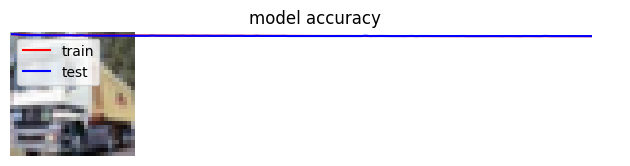

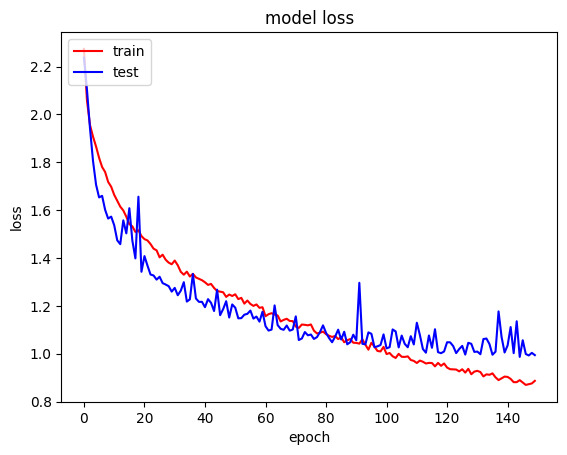

In [9]:
# Plot of the training history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# Convert one-hot encoded y_test back to class indices for comparison
y_test_labels = np.argmax(y_test, axis=1)

# Now you can generate the classification report
print('\nClassification Report:')
print(classification_report(y_test_labels, y_pred))

# Confusion matrix
cf = confusion_matrix(y_test_labels, y_pred)
print('\nConfusion Matrix:')
print(cf)

# Accuracy
print(f'\nAccuracy: {accuracy_score(y_test_labels, y_pred) * 100:.2f}%')


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1000
           1       0.77      0.79      0.78      1000
           2       0.52      0.53      0.52      1000
           3       0.51      0.41      0.45      1000
           4       0.60      0.57      0.58      1000
           5       0.62      0.46      0.52      1000
           6       0.62      0.83      0.71      1000
           7       0.74      0.71      0.73      1000
           8       0.70      0.83      0.76      1000
           9       0.73      0.76      0.75      1000

    accuracy                           0.66     10000
   macro avg       0.65      0.66      0.65     10000
weighted avg       0.65      0.66      0.65     10000


Confusion Matrix:
[[683  24  61  13  13   2  13   9 135  47]
 [ 25 785   5   6   3   0  11   5  52 108]
 [ 84   8 531  47  97  54 105  33  27  14]
 [ 23  19  90 405  79 135 155  39  31  24]
 [ 33   8 131  39 566  18 

### Transferlearning via VGG19

In [12]:
modelVGG19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(32,32,3))
type(modelVGG19)

keras.src.models.functional.Functional

In [13]:
# Convert to Keras model

model = Sequential()

for layer in modelVGG19.layers[:]:
    model.add(layer)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# set coefficients to fixed

for layer in model.layers:
    layer.trainable = False

# Add custom dense layers

model.add(Flatten()) 
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10,activation='softmax'))

In [15]:
adam = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',optimizer =adam,metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,077,094 (76.59 MB)

 Trainable params: 52,510 (205.12 KB)

 Non-trainable params: 20,024,584 (76.39 MB)

In [16]:
X_train = preprocess_input(X_train)

In [17]:
# Train VGG model
batch_size =256
epochs = 20
history = model.fit(X_train, y_train, batch_size=batch_size,  shuffle= True,validation_split =0.2, epochs=epochs, verbose=1)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 969ms/step - accuracy: 0.1714 - loss: 2.3219 - val_accuracy: 0.0990 - val_loss: 7.4623
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 930ms/step - accuracy: 0.3038 - loss: 1.9293 - val_accuracy: 0.0990 - val_loss: 9.7041
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 932ms/step - accuracy: 0.3333 - loss: 1.8463 - val_accuracy: 0.0990 - val_loss: 10.0727
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3606 - loss: 1.7985 - val_accuracy: 0.0990 - val_loss: 9.9472
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 953ms/step - accuracy: 0.3870 - loss: 1.7313 - val_accuracy: 0.0990 - val_loss: 8.2946
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 918ms/step - accuracy: 0.3874 - loss: 1.7175 - val_accuracy: 0.1000 - val_loss: 8.8520
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 915ms/step - accuracy: 0.4131 - loss: 1.6800 - val_accuracy: 0.1045 - val_loss: 8.7436
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 938ms/step - accuracy: 0.4101 - loss: 1.6576 - val_accura